# Imports

In [1]:

import numpy as np
import scipy
import pandas as pd
from scipy import special
from scipy.stats import binom, gamma
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import itertools
import os
import plotnine
from plotnine import *
import warnings
import pygsheets


warnings.filterwarnings("ignore")

In [2]:
## import custom-written functions
import sys
sys.path.append('..')
from labtools import abtesting, plotting_themes
output_dir = '/home/jovyan/work/OVSJG-SUSO/probabilities/output/'


# First replicate Table 1 from original PAP (binary engagement outcome)

### Replicate table 1

#### Original code

In [3]:
def degree_of_certainty(successes_a, failures_a, successes_b, failures_b):
    the_range = np.arange(successes_b + 1)
    conditional_a = special.betaln(successes_a + 1, failures_a + 1)
    return np.sum(np.exp(
                    special.betaln(1 + successes_a + the_range, failures_a + failures_b + 2)
                  - np.log(1 + failures_b + the_range)
                  - special.betaln(1 + the_range, 1 + failures_b)
                  - conditional_a))

In [4]:
## original results: https://github.com/thelabdc/OVSJG-SUSO/blob/master/probabilities/SUSO%20Certainty%20Calculations.ipynb


for N in [400,600,1200]:
    for base_rate in [0.075,]:
        for er in [base_rate+0.01, base_rate+0.02, base_rate+0.04, base_rate+0.08, ]: 
            engaged = round(er*N)
            successes_b = engaged
            failures_b = N - successes_b
            successes_a = round(base_rate * N)
            failures_a = N - successes_a
            doc = degree_of_certainty(successes_a, failures_a, successes_b, failures_b)
            improvement = (engaged/N)-base_rate
            print([N*2, base_rate, round(improvement,3),round(doc,2)])


[800, 0.075, 0.01, 0.69999999999999996]
[800, 0.075, 0.02, 0.83999999999999997]
[800, 0.075, 0.04, 0.96999999999999997]
[800, 0.075, 0.08, 1.0]
[1200, 0.075, 0.01, 0.73999999999999999]
[1200, 0.075, 0.02, 0.89000000000000001]
[1200, 0.075, 0.04, 0.98999999999999999]
[1200, 0.075, 0.08, 1.0]
[2400, 0.075, 0.01, 0.81999999999999995]
[2400, 0.075, 0.02, 0.95999999999999996]
[2400, 0.075, 0.04, 1.0]
[2400, 0.075, 0.08, 1.0]


#### Table 1 when we generalize to *m* draws from the distribution

In [5]:
all_combos_sample_improvement = abtesting.create_combinations_certanalysis(sample_sizes = [800, 1200, 2400],
                                                                effect_sizes = [0.01, 0.02, 0.04, 0.08],
                                                                base_rates = [0.075])


In [10]:
all_probabilities = [abtesting.find_probability_acrossdraws(one_combo, 
                                                       type_of_outcome = "binary",
                                                       direction = "increase",
                                                       num_draws = 10000) 
                     for one_combo in all_combos_sample_improvement]

In [11]:
prob_results = pd.DataFrame({'sample_size': [x[0] for x in all_combos_sample_improvement],
                            'percentage_point_improvement_over_base': [x[1] for x in all_combos_sample_improvement],
                            'probability': all_probabilities})

In [12]:
## reshape so that percent improvement is the pivot column
prob_results_wide = prob_results.pivot(index = 'percentage_point_improvement_over_base', columns = 'sample_size', values = 'probability')
prob_results_wide['degree_improvement_init'] = prob_results_wide.index*100
prob_results_wide['degree_improvement'] = "Improvement: + " + prob_results_wide.degree_improvement_init.astype(str) + "%"

In [13]:
## note: get slightly different numbers when doing with more draws but that should be fine
standard_colnames = [str(x) + " eligible families" if str(x).isdigit()
                     else x for x in prob_results_wide.columns]
prob_results_wide.columns = standard_colnames
standard_colnames_order = ["degree_improvement"] + [col for col in standard_colnames if "eligible" in col]

In [14]:

prob_results_wide_2write = prob_results_wide[standard_colnames_order].copy().round(2)

In [15]:
prob_results_wide_2write

,degree_improvement,800 eligible families,1200 eligible families,2400 eligible families
percentage_point_improvement_over_base,,,,
0.01,Improvement: + 1.0%,0.12,0.14,0.21
0.02,Improvement: + 2.0%,0.25,0.33,0.53
0.04,Improvement: + 4.0%,0.60,0.75,0.95
0.08,Improvement: + 8.0%,0.97,1.00,1.00


In [16]:
def write_table_togooglesheet(pathname_gcreds,
                             sheet_url,
                             worksheet_name,
                             pandas_df, newsheet= True):
    
    
    ## creates client
    google_client = pygsheets.authorize(service_file = pathname_gcreds)
    
    ## opens all sheets using url
    all_sheets = google_client.open_by_url(sheet_url)
    
    ## if adding a new sheet
    if newsheet == True:
        all_sheets.add_worksheet(worksheet_name)
        one_sheet = all_sheets.worksheet_by_title(worksheet_name)
        one_sheet.set_dataframe(pandas_df, start= "A1")
        return None
    else:
        one_sheet = all_sheets.worksheet_by_title(worksheet_name)
        one_sheet.set_dataframe(pandas_df, start= "A1")
        return None
    
    

#### Figure that varies base rates 

In [17]:
effect_sizes_engagement = list(np.arange(0, 0.09, 0.01).flatten())

In [18]:
## Now vary for the base rate for graph
all_combos_sample_improvement_baseratevary = abtesting.create_combinations_certanalysis(sample_sizes = [800, 1200, 2400],
                                                                effect_sizes = effect_sizes_engagement,
                                                                base_rates = [0.05, 0.075, 0.1])

In [19]:
## gen probabilities (takes some time to run)
all_probabilities_forgraph = [abtesting.find_probability_acrossdraws(one_combo, 
                                                       type_of_outcome = "binary",
                                                       direction = "increase",
                                                       num_draws = 10000) 
                     for one_combo in all_combos_sample_improvement_baseratevary]

In [371]:
prob_results_forgraph = pd.DataFrame({'sample_size': [x[0] for x in all_combos_sample_improvement_baseratevary],
                            'percent_point_improvement_over_base': [x[1] for x in all_combos_sample_improvement_baseratevary],
                            'base_rate': [x[2] for x in all_combos_sample_improvement_baseratevary],
                            'probability': all_probabilities_forgraph})
          

prob_results_forgraph['base_rate_descriptive'] = "Base rate: " + prob_results_forgraph.base_rate.map(str)


In [372]:
prob_results_forgraph.head()

,sample_size,percent_point_improvement_over_base,base_rate,probability,base_rate_descriptive
0,800,0.00,0.050,0.0477,Base rate: 0.05
1,800,0.00,0.075,0.0442,Base rate: 0.075
2,800,0.00,0.100,0.0428,Base rate: 0.1
3,800,0.01,0.050,0.1476,Base rate: 0.05
4,800,0.01,0.075,0.1218,Base rate: 0.075


In [373]:
## define background in-text for now and then update separate script
background_effectsize_smaller = theme(panel_background = element_blank(),   
       panel_grid_major_y = element_blank(),
      axis_text_x = element_text(color = "black", angle = 90,  hjust = 1, size = 12),
      axis_text_y = element_text(color = "black", size = 12),
    legend_text = element_text(color = 'black', size = 12),
    legend_title = element_text(color = 'black', size = 12),
      axis_title=element_text(size=12),
    strip_text_x = element_text(size = 12),
    legend_background = element_blank(),
    legend_key = element_blank(),
    panel_grid_major = element_blank(), 
    panel_grid_minor = element_blank())

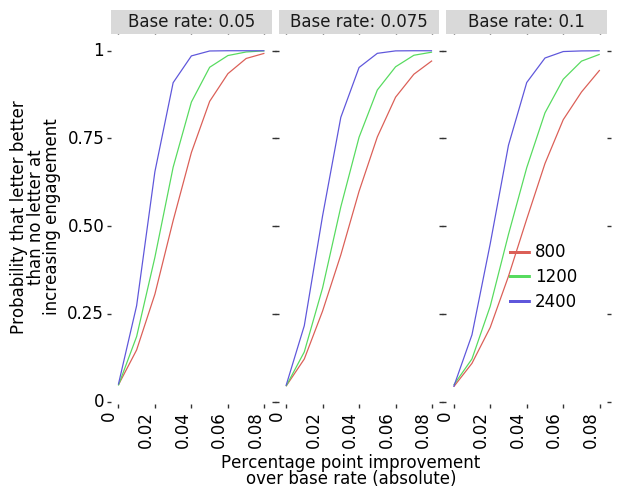

<ggplot: (8771591165041)>

In [374]:

##plot with facets
(ggplot(prob_results_forgraph, aes(x = 'percent_point_improvement_over_base',
                          y = 'probability',
                            color = 'factor(sample_size)')) +
         geom_line()  +
         xlab('Percentage point improvement\nover base rate (absolute)') +
         ylab("Probability that letter better\nthan no letter at\nincreasing engagement") +
         labs(color = "") +
         facet_wrap('~base_rate_descriptive') +
         background_effectsize_smaller +
        theme(legend_position = (0.8, 0.4)))

In [375]:
## order by sample size and base rate
## and then create ordered factor
prob_results_forgraph_ordered = prob_results_forgraph.sort_values(by = ['sample_size'],
                                                                 ascending = False)
prob_results_forgraph_ordered['legend_descriptive'] = prob_results_forgraph_ordered.base_rate_descriptive + "\nSample size: " + prob_results_forgraph_ordered.sample_size.map(str)


In [376]:
order_for_categories = ["Base rate: 0.05\nSample size: " + str(x) for x in [800, 1200, 2400]] + ["Base rate: 0.075\nSample size: " + str(x) for x in [800, 1200, 2400]] +["Base rate: 0.1\nSample size: " + str(x) for x in [800, 1200, 2400]]
order_for_categories

['Base rate: 0.05\nSample size: 800',
 'Base rate: 0.05\nSample size: 1200',
 'Base rate: 0.05\nSample size: 2400',
 'Base rate: 0.075\nSample size: 800',
 'Base rate: 0.075\nSample size: 1200',
 'Base rate: 0.075\nSample size: 2400',
 'Base rate: 0.1\nSample size: 800',
 'Base rate: 0.1\nSample size: 1200',
 'Base rate: 0.1\nSample size: 2400']

In [377]:
prob_results_forgraph_ordered['legend_descriptive_cat'] = pd.Categorical(prob_results_forgraph_ordered['legend_descriptive'],
                                                                           order_for_categories)

In [28]:
background_effectsize_smaller_legend = theme(panel_background = element_blank(),   
       panel_grid_major_y = element_blank(),
      axis_text_x = element_text(color = "black", angle = 90,  hjust = 1, size = 12),
      axis_text_y = element_text(color = "black", size = 12),
    legend_text = element_text(color = 'black', size = 10),
    legend_title = element_text(color = 'black', size = 12),
      axis_title=element_text(size=12),
    strip_text_x = element_text(size = 12),
    legend_background = element_blank(),
    legend_key = element_blank(),
    panel_grid_major = element_blank(), 
    panel_grid_minor = element_blank())

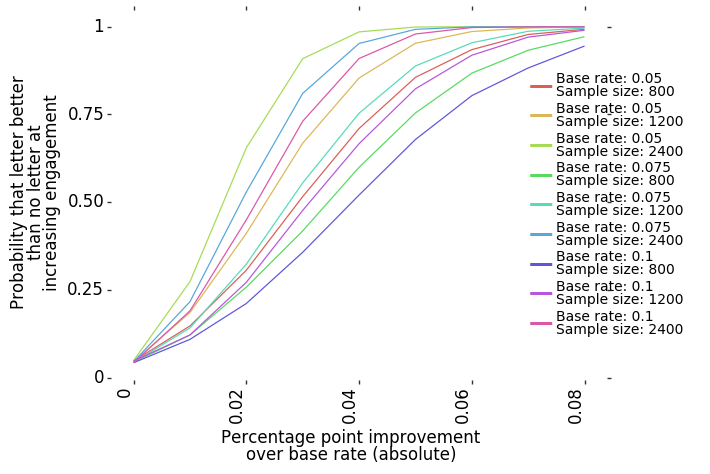

<ggplot: (-9223363265274207905)>

In [379]:
## plot without facets
(ggplot(prob_results_forgraph_ordered, aes(x = 'percent_point_improvement_over_base',
                          y = 'probability',
                            color = 'legend_descriptive_cat')) +
         geom_line()  +
         xlab('Percentage point improvement\nover base rate (absolute)') +
         ylab("Probability that letter better\nthan no letter at\nincreasing engagement") +
         labs(color = "") +
         background_effectsize_smaller_legend +
        theme(legend_position = (0.9, 0.5)))

# Attendance binary outcomes

Same procedure as above but with different base rates

In [21]:
effect_sizes_engagement = list(np.arange(0, 0.09, 0.01).flatten())
all_combos_improvement_truancy = all_combos_sample_improvement = abtesting.create_combinations_certanalysis(sample_sizes = [800, 1200, 2400],
                                                effect_sizes = [0.01, 0.02, 0.04, 0.08],
                                              base_rates = [0.35, 0.40, 0.45, 0.50])
all_combos_improvement_ca = all_combos_sample_improvement = abtesting.create_combinations_certanalysis(sample_sizes = [800, 1200, 2400],
                                                effect_sizes = [0.01, 0.02, 0.04, 0.08],
                                              base_rates = [0.30, 0.35, 0.40, 0.45])



## Truancy: table and figure

### Table: holding the base rate constant

In [22]:
all_probabilities_truancy = [abtesting.find_probability_acrossdraws(one_combo, 
                                                       type_of_outcome = "binary",
                                                       direction = "decrease",
                                                       num_draws = 10000) 
                     for one_combo in all_combos_improvement_truancy]

In [23]:
prob_results_truancy = pd.DataFrame({'sample_size': [x[0] for x in all_combos_improvement_truancy],
                            'percentage_point_decrease_over_base': [x[1] for x in all_combos_improvement_truancy],
                            'base_rate': [x[2] for x in all_combos_improvement_truancy],
                            'probability_control_greaterthan_treatment': all_probabilities_truancy})

In [24]:

## subset to assumed base rate for purposes of table
prob_results_truancy_obsbase = prob_results_truancy.loc[prob_results_truancy.base_rate.isin([0.40])].copy()
prob_results_truancy_obsbase_wide = prob_results_truancy_obsbase.pivot(index = 'percentage_point_decrease_over_base', 
                                                 columns = 'sample_size', values = 'probability_control_greaterthan_treatment')
prob_results_truancy_obsbase_wide

## write to latex
#print(prob_results_truancy_obsbase_wide.round(2).to_latex())
prob_results_truancy_obsbase_wide.round(2)

sample_size,800,1200,2400
percentage_point_decrease_over_base,,,
0.01,0.0505,0.0577,0.0785
0.02,0.0932,0.1215,0.1930
0.04,0.2459,0.3281,0.5526
0.08,0.6921,0.8505,0.9888


sample_size,800,1200,2400
percentage_point_decrease_over_base,,,
0.01,0.05,0.06,0.08
0.02,0.09,0.12,0.19
0.04,0.25,0.33,0.55
0.08,0.69,0.85,0.99


In [25]:
## format table
prob_results_truancy_obsbase_wide['degree_improvement_init'] = prob_results_truancy_obsbase_wide.index*100
prob_results_truancy_obsbase_wide['degree_improvement'] = "Improvement: - " + prob_results_truancy_obsbase_wide.degree_improvement_init.astype(str) + "%"
standard_colnames = [str(x) + " eligible families" if str(x).isdigit()
                     else x for x in prob_results_truancy_obsbase_wide.columns]
prob_results_truancy_obsbase_wide.columns = standard_colnames
standard_colnames_order = ["degree_improvement"] + [col for col in standard_colnames if "eligible" in col]
prob_truancy_results_wide_2write = prob_results_truancy_obsbase_wide[standard_colnames_order].copy().round(2)


### Figure: varying the base rate

In [26]:
prob_results_truancy['base_rate_descriptive'] = "Base rate:" + prob_results_truancy.base_rate.map(str)

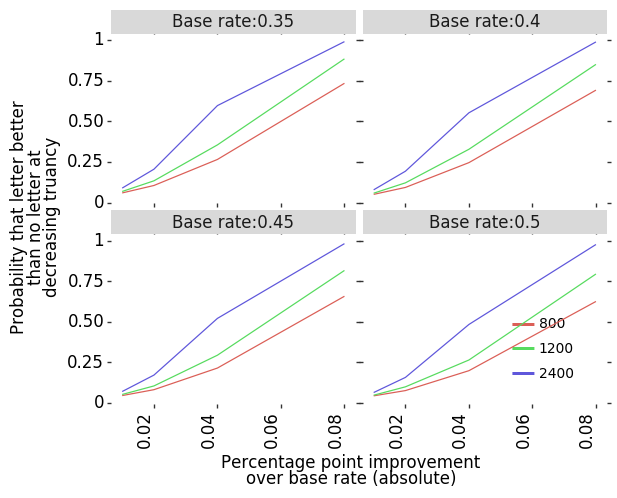

<ggplot: (8737437335784)>

In [29]:
(ggplot(prob_results_truancy, aes(x = 'percentage_point_decrease_over_base',
                          y = 'probability_control_greaterthan_treatment',
                            color = 'factor(sample_size)')) +
         geom_line()  +
         xlab('Percentage point improvement\nover base rate (absolute)') +
         ylab("Probability that letter better\nthan no letter at\ndecreasing truancy") +
         labs(color = "") +
         facet_wrap('~base_rate_descriptive') +
         background_effectsize_smaller_legend +
        theme(legend_position = (0.8, 0.25))) 

## Chronic absenteeism: tables and figures

### Table: holding the base rate fixed

In [30]:
all_probabilities_ca = [abtesting.find_probability_acrossdraws(one_combo, 
                                                       type_of_outcome = "binary",
                                                       direction = "decrease",
                                                       num_draws = 10000) 
                     for one_combo in all_combos_improvement_ca]

In [31]:
prob_results_ca = pd.DataFrame({'sample_size': [x[0] for x in all_combos_improvement_ca],
                            'percentage_point_decrease_over_base': [x[1] for x in all_combos_improvement_ca],
                            'base_rate': [x[2] for x in all_combos_improvement_ca],
                            'probability_control_greaterthan_treatment': all_probabilities_ca})


## subset to assumed base rate for purposes of table
prob_results_ca_obsbase = prob_results_ca.loc[prob_results_ca.base_rate.isin([0.35])].copy()
prob_results_ca_obsbase_wide = prob_results_ca_obsbase.pivot(index = 'percentage_point_decrease_over_base', 
                                                 columns = 'sample_size', values = 'probability_control_greaterthan_treatment')
prob_results_ca_obsbase_wide.round(2)



sample_size,800,1200,2400
percentage_point_decrease_over_base,,,
0.01,0.06,0.07,0.09
0.02,0.11,0.14,0.22
0.04,0.26,0.36,0.60
0.08,0.74,0.88,0.99


In [32]:
## format tables
prob_results_ca_obsbase_wide['degree_improvement_init'] = prob_results_ca_obsbase_wide.index*100
prob_results_ca_obsbase_wide['degree_improvement'] = "Improvement: - " + prob_results_ca_obsbase_wide.degree_improvement_init.astype(str) + "%"
standard_colnames = [str(x) + " eligible families" if str(x).isdigit()
                     else x for x in prob_results_ca_obsbase_wide.columns]
prob_results_ca_obsbase_wide.columns = standard_colnames
standard_colnames_order = ["degree_improvement"] + [col for col in standard_colnames if "eligible" in col]
prob_ca_results_wide_2write = prob_results_ca_obsbase_wide[standard_colnames_order].copy().round(2)


### Figure: varying the base rate

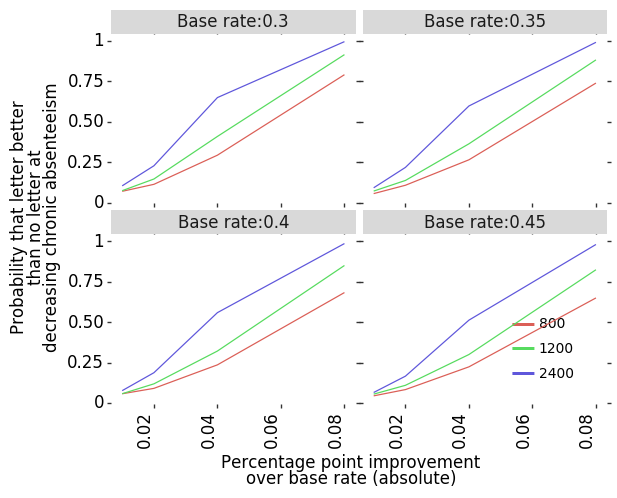

<ggplot: (-9223363299422125189)>

In [34]:
prob_results_ca['base_rate_descriptive'] = "Base rate:" + prob_results_ca.base_rate.map(str)
(ggplot(prob_results_ca, aes(x = 'percentage_point_decrease_over_base',
                          y = 'probability_control_greaterthan_treatment',
                            color = 'factor(sample_size)')) +
         geom_line()  +
         xlab('Percentage point improvement\nover base rate (absolute)') +
         ylab("Probability that letter better\nthan no letter at\ndecreasing chronic absenteeism") +
         labs(color = "") +
         facet_wrap('~base_rate_descriptive') +
         background_effectsize_smaller_legend +
        theme(legend_position = (0.8, 0.25))) 

# Attendance count outcomes

See following notebook for verification that function produces intuitive results: https://github.com/thelabdc/LAB-PythonTools/blob/master/labtools/abtesting_countdata_indev.ipynb

## Table holding base rate fixed

In [35]:
all_combos_sample_count_improvement = abtesting.create_combinations_certanalysis(sample_sizes = [800, 1200, 2400],
                                                                effect_sizes = [0.05, 0.1, 0.15, 0.3],
                                                                base_rates = [0.7])

In [37]:
## returns prob tx < control
prob_count_txlessthancontrol = [abtesting.find_probability_acrossdraws(one_combo, 
                                                       type_of_outcome = "count",
                                                       direction = "decrease",
                                                       num_draws = 10000, 
                                                    exposure = 10) 
                     for one_combo in all_combos_sample_count_improvement]


In [38]:
## bind into a dataframe and print output
prob_count_results = pd.DataFrame({'sample_size': [x[0] for x in all_combos_sample_count_improvement],
                            'improvement_over_base': [x[1] for x in all_combos_sample_count_improvement],
                            'probability': prob_count_txlessthancontrol})


In [39]:
prob_count_results_wide = prob_count_results.pivot(index = "improvement_over_base",
                                                  columns = 'sample_size',
                                                  values = 'probability')

In [40]:
prob_count_results_wide.round(2)

sample_size,800,1200,2400
improvement_over_base,,,
0.05,0.22,0.27,0.43
0.10,0.54,0.69,0.92
0.15,0.85,0.95,1.00
0.30,1.00,1.00,1.00


In [41]:
## format and write to google sheets
prob_count_results_wide['improvement_over_base'] = prob_count_results_wide.index
prob_count_results_wide['degree_improvement'] = "Improvement: - " + prob_count_results_wide.improvement_over_base.astype(str) + " days"
standard_colnames = [str(x) + " eligible families" if str(x).isdigit()
                     else x for x in prob_count_results_wide.columns]
prob_count_results_wide.columns = standard_colnames
standard_colnames_order = ["degree_improvement"] + [col for col in standard_colnames if "eligible" in col]
prob_count_results_wide_2write = prob_count_results_wide[standard_colnames_order].copy().round(2)


## Figure that varies the base rate


In [42]:
effect_size_count = list(np.arange(0, 0.35, 0.05).flatten())

In [43]:
all_combos_sample_count_improvement_varybase = abtesting.create_combinations_certanalysis(sample_sizes = [800, 1200, 2400],
                                                                effect_sizes = effect_size_count,
                                                                base_rates = [0.4, 0.7, 1])
#all_combos_sample_count_improvement_varybase

In [44]:
prob_count_txlessthancontrol_varybase = [abtesting.find_probability_acrossdraws(one_combo, 
                                                       type_of_outcome = "count",
                                                       direction = "decrease",
                                                       num_draws = 10000, 
                                                    exposure = 10) 
                     for one_combo in all_combos_sample_count_improvement_varybase]

In [398]:

#prob_count_txlessthancontrol_varybase

In [45]:
prob_count_results_varybase = pd.DataFrame({'sample_size': [x[0] for x in all_combos_sample_count_improvement_varybase],
                            'improvement_over_base': [x[1] for x in all_combos_sample_count_improvement_varybase],
                            'base_count_absences':  [x[2] for x in all_combos_sample_count_improvement_varybase],
                            'probability': prob_count_txlessthancontrol_varybase})

In [46]:
prob_count_results_varybase['base_count_descriptive'] = "Base count: " + prob_count_results_varybase.base_count_absences.map(str)

                                        

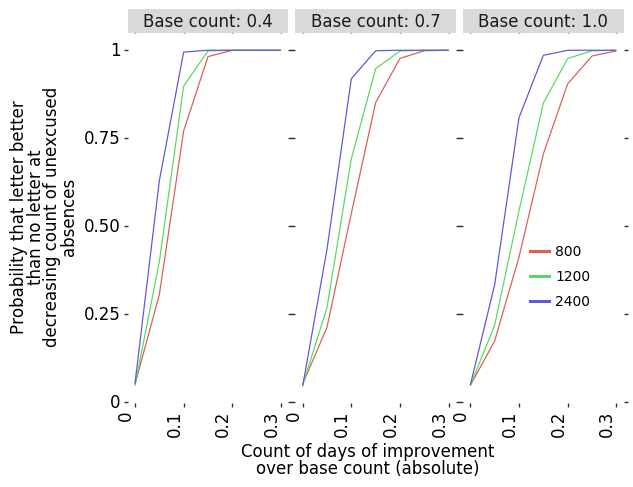

<ggplot: (8737432655368)>

In [48]:
(ggplot(prob_count_results_varybase, aes(x = 'improvement_over_base',
                          y = 'probability',
                            color = 'factor(sample_size)')) +
         geom_line()  +
         xlab('Count of days of improvement\nover base count (absolute)') +
         ylab("Probability that letter better\nthan no letter at\ndecreasing count of unexcused\nabsences") +
         labs(color = "") +
         facet_wrap('~base_count_descriptive') +
         background_effectsize_smaller_legend +
        theme(legend_position = (0.8, 0.4)))